# Biodiversity Intactness Index change in Phoenix subdivision
Amanda Herbst, MEDS '24

**Link to GitHub repository:** https://github.com/amandaherbst/eds220-phx-biodiversity-loss

## About

### Purpose
In 2021, Maricopa County, which encompasses the Phoenix metropolitan area, was the US county that added the most developed land since 2001. Urban sprawl creates pressure on biodiversity and natural areas. In this analysis we will explore a dataset showing values for a biodiversity intactness index (BII) to find changes in this BII around the Phoenix area from 2017 to 2020. 

### Analysis Highlights
- Visualize raster data
- Accessing MPC STAC collection
- Manipulating raster data via `rioxarray`
- Plotting with `Matplotlib.pyplot`

### Dataset Descriptions

**(1) Arizona County Subdivision TIGER/Line Shapefiles**

Shapefiles from the United States Census Bureau of all counties in the state of Arizona.

**(2) Biodiversity Intactness Index (BII) raster data**

Datasets accessed via the Microsoft Planetary Computer estimating terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020. Biodiversity intactness is estimated as a combination of two metrics: Abundance, the quantity of individuals, and Compositional Similarity, how similar the composition of species is to an intact baseline. Linear mixed effects models are fit to estimate the predictive capacity of spatial datasets of human pressures on each of these metrics and project results spatially across the globe.

### References

Microsoft Planetary Computer. *Biodiversity Intactness* [Dataset]. Available from https://planetarycomputer.microsoft.com/dataset/io-biodiversity. Accessed 6 December 2023

US Census Bureau, Geography Division (2022). *Arizona Census County Subdivision 2022 TIGER Shapefiles* [Data File]. Available from https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions. Accessed 6 December 2023

## Import libraries and functions:

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for creating legends

import contextily as ctx #for adding basemaps

import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box

import pystac_client
import planetary_computer

## Phoenix subdivision -- Geographical Context

### Importing shapefiles

Load Arizona county shapefiles (saved locally) and select "Phoenix." We will use the geometry for plotting and clipping other rasters.

In [2]:
# counties shapefile
az_counties = gpd.read_file('data/tl_2022_04_cousub/tl_2022_04_cousub.shp')

# phoenix polygon
phx = az_counties[az_counties.NAME == "Phoenix"]

### Mapping Phoenix

Plotting Phoenix polygon over a basemap of the area in Arizona acquired from Esri for geographical context.

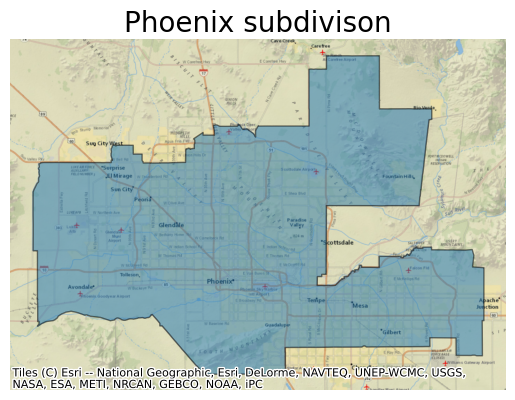

In [3]:
# plot phoenix with geographical context
fig, ax = plt.subplots()

# convert to epsg 2857 for compatability with basemaps
(phx.to_crs(epsg=3857)
 .plot(ax = ax, figsize = (7,7), alpha = 0.5, edgecolor = 'k'))

# add basemap
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.NatGeoWorldMap)

ax.set_title('Phoenix subdivison', fontdict = {'fontsize':'20'})
ax.set_axis_off()

## Biodiversity Intactness Index (BII)

Load BII data from the MPC STAC catalog with coordinates defining a bounding box around Phoenix and selecting years 2017-2020.

In [4]:
# open catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# coords defining bbox around phoenix
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# search
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = '2017/2020'
)

Check out the items in our search! Since we selected a range of years we got 4 items, but we only want 2: 2017 and 2020

In [5]:
items = search.item_collection()
items

id: bii_2020_34.74464974521749_-115.38597824385106_cog
"bbox: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2020-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2020-01-01T00:00:00Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json
https://stac-extensions.github.io/version/v1.1.0/schema.json


Looking at the collection of items, it looks like the 4th item references the 2017 raster and the 1st item references the 2020 item. I will select those items by indexing and open the raster data using `rioxr.open_rasterio()`.

In [6]:
item_2017 = items[3]
item_2020 = items[0]

phx_17 = rioxr.open_rasterio(item_2017.assets['data'].href)
phx_20 = rioxr.open_rasterio(item_2020.assets['data'].href)

### Data preparation for Analysis and Visualization

We need to clip the raster data to the Phoenix subdivision which requires everything has the same CRS. Once that is true, we can clip the rasters to the Phoenix geometry and plot to verify.

In [7]:
print("phx 2017 bii crs: ", phx_17.rio.crs)
print("phx 2020 bii crs: ", phx_20.rio.crs)
print("phx county crs: ", phx.crs)

phx 2017 bii crs:  EPSG:4326
phx 2020 bii crs:  EPSG:4326
phx county crs:  EPSG:4269


Looks like the county shapefile is a different CRS so let's reproject it to that of the raster data and check that it was successful:

In [8]:
phx = phx.to_crs(phx_17.rio.crs)
# check
print('matched crs?',  phx.crs == phx_17.rio.crs)

matched crs? True


Clip rasters using `rio.clip()` method and drop the extra dimension in the same step. Plot one of the clipped rasters to verify.

In [ ]:
# clip
# clip rasters to phx
phx_17_clip = phx_17.rio.clip(phx.geometry).squeeze().drop('band')
phx_20_clip = phx_20.rio.clip(phx.geometry).squeeze().drop('band')

# check clipping
phx_17_clip.plot.imshow()

## Percentage area of Phoenix subdivison with BII of at least 0.75 in 2017 and 2020

Now that we have the raster data successfully clipped to the geometry of the Phoenix subdivision, we can begin our analysis. First, we can calculate the percentage of area in Phoenix with a BII of at least 0.75 in both 2017 and 2020 using the number of pixels in the raster. We can do this by creating a mask indicating areas with BII of at least 0.75, then count those pixels, and finally divide by the toal number of pixels in Phoenix to get a percent value.


In [ ]:
# create mask with BII of at least 0.75
phx_17_mask = (phx_17_clip >= 0.75).astype(int)
phx_20_mask = (phx_20_clip >= 0.75).astype(int)

# count the number of pixels labeled 0 and labeled 1
code, pixels_17 = np.unique(phx_17_mask, return_counts = True)
code, pixels_20 = np.unique(phx_20_mask, return_counts = True)

# organize pixel counts 
d = {
    'code': code,
    'num_pixels_17': pixels_17,
    'num_pixels_20': pixels_20
}

pix_counts = pd.DataFrame(d)
pix_counts

The table above shows how many pixels are 1s (BII ≥ 0.75) and 0s. Unfortunately, the NaNs in the clipped raster were converted to 0s when making the masks. Therefore, we need to calculate the total pixels in *Phoenix only* by counting the total pixels in the clipped rasters. Then we can calculate an accurate percentage.

In [ ]:
# total count pixels in phoenix
# NA pixels in the clip are transformed to 0s when making the mask
tot_phx_17_pixels = phx_17_clip.count().item()
tot_phx_20_pixels = phx_20_clip.count().item()

# calculate percentage of area using the pixels outputs from above
pct_area_17 = pixels_17[1]/(tot_phx_17_pixels)*100
pct_area_20 = pixels_20[1]/(tot_phx_20_pixels)*100

print(round(pct_area_17,2), "% of the Phoenix subdivision had a BII of at least 0.75 in 2017.")
print(round(pct_area_20,2), "% of the Phoenix subdivision had a BII of at least 0.75 in 2020.")

## Visualization of biodiversity loss in Phoenix

Based on our calculations above, Phoenix lost 0.64% of BII area ≥ 0.75 from 2017 to 2020. Let's visualize this loss by finding the specific locations where biodiversity was lost. 

### Raster Preparation

When we subtract the 2020 mask from the 2017 mask, any pixels with the value 1 will indicate biodiversity loss. 

In [ ]:
# calculate biodiversity lost by subtracting 2020 mask from 2017
# this way, any pixel that lost biodiversity will be designated by a 1
area_loss = (phx_17_mask - phx_20_mask)

# convert -1 and 0 values to nan values
area_loss = area_loss.where(area_loss == 1)

# verify the raster only contains 1s and nans
np.unique(area_loss)

## Plot: Biodiveristy Loss in Phoenix from 2017 to 2020

We are plotting the biodiveristy intactness index across Phoenix in 2020 and then adding the areas where biodiversity was lost in red. This way, we can visualize if there were specific areas that had more loss than others.

In [ ]:
# create final plot figure and axes
fig, ax = plt.subplots(figsize = (5, 5))

#-------------------------------------------------------------------------------------------
# plot 2020 phoenix BII
phx_20_clip.plot(ax = ax,
                 cmap = "Greens",
                 cbar_kwargs={'orientation':'horizontal',
                            'label':'2020 BII'})
#-------------------------------------------------------------------------------------------
# add outline of phoenix subdivision
phx.plot(ax = ax,
         color = "none",
         edgecolor = 'black')
#-------------------------------------------------------------------------------------------
# add area with high biodiversity lost from 2017 to 2020
area_loss.plot(ax = ax,
               cmap = "brg", 
               add_colorbar=False)

# create patch for legend
loss_patch = mpatches.Patch(color = 'red',
                           label = 'Area with BII ≥ 0.75 lost from 2017 to 2020')
#-------------------------------------------------------------------------------------------
# add legend indicating what the red is
ax.legend(handles = [loss_patch],
         frameon = False,
         loc = (0.1,-0.2),
         fontsize = 9)

# turn off lat/lon axes
ax.axis('off')

# add plot title
plt.title('Biodiversity Intactness Index (BII) - Phoenix Subdivision')
plt.show()
